# Get related data

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("YourAppName")  \
    .config("spark.executor.memory", "6g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

transactions = spark.read.parquet("../data/curated/curated_transaction")
transactions = transactions.drop("log_dollar_value", "order_id")
transactions.show(3)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/01 08:07:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------+------------+------------------+--------------+
|user_id|merchant_abn|      dollar_value|order_datetime|
+-------+------------+------------------+--------------+
|  14935| 79417999332|136.06570809815838|    2021-11-26|
|      1| 46451548968| 72.61581642788431|    2021-11-26|
|  14936| 89518629617|3.0783487174439297|    2021-11-26|
+-------+------------+------------------+--------------+
only showing top 3 rows



In [2]:
from pyspark.sql import functions as F

# Group by merchant_abn, order_datetime, and user_id, then sum the dollar_value
transactions_grouped = transactions.groupBy('merchant_abn', 'order_datetime', 'user_id') \
                                   .agg(F.sum('dollar_value').alias('total_dollar_value'))

# Show the result
transactions_grouped.show(5)

24/10/01 08:07:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:07:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:07:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:07:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:07:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:07:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:07:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:07:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:07:27 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+--------------+-------+------------------+
|merchant_abn|order_datetime|user_id|total_dollar_value|
+------------+--------------+-------+------------------+
| 52959528548|    2021-11-26|  14967| 645.6459664910478|
| 41881349154|    2021-11-26|     55| 74.49956514916703|
| 52242018594|    2021-11-26|  15003| 82.04700162722082|
| 81877438808|    2021-11-26|  15101|26.932213280447307|
| 96152467973|    2021-11-26|    187| 62.17978228509556|
+------------+--------------+-------+------------------+
only showing top 5 rows



In [3]:
# Get user fraud rate by date
user_fraud = spark.read.parquet("../data/curated/user_fraud_by_date.parquet")
user_fraud.show(5)

+-------+--------------+--------------------+
|user_id|order_datetime|   fraud_probability|
+-------+--------------+--------------------+
|      1|    2021-03-02| 0.04133541770704879|
|      1|    2021-03-20|0.034287051454195194|
|      1|    2021-03-31|0.035936521365319087|
|      1|    2021-04-03|0.048465117631272196|
|      1|    2021-04-11|0.033987067860580034|
+-------+--------------+--------------------+
only showing top 5 rows



In [4]:
# Get merchants data
merchants = spark.read.parquet("../data/curated/curated_merchants")
merchants = merchants.drop("name", "type", "rev_level")
merchants.show(3)

+------------+---------+
|merchant_abn|take_rate|
+------------+---------+
| 10023283211|     0.18|
| 10142254217|     4.22|
| 10187291046|     3.29|
+------------+---------+
only showing top 3 rows



# Combine the data

In [5]:
# Perform a full outer join between transactions and user_fraud on user_id and order_datetime
transactions_user_fraud = transactions.join(user_fraud, 
                                              on=['user_id', 'order_datetime'], how="inner")

# Show the first 5 rows of the joined result
transactions_user_fraud.show(5)

+-------+--------------+------------+------------------+-------------------+
|user_id|order_datetime|merchant_abn|      dollar_value|  fraud_probability|
+-------+--------------+------------+------------------+-------------------+
|      1|    2021-03-11| 86578477987|23.300617635489033|0.03373424948018306|
|      1|    2021-03-21| 72472909171| 26.84427554025195|0.04324741361124939|
|      1|    2021-03-21| 86010199872|218.49116722954264|0.04324741361124939|
|      1|    2021-04-29| 90796680287|12.246844545453301|0.05392116373834903|
|      1|    2021-04-29| 96680767841| 677.3472120814281|0.05392116373834903|
+-------+--------------+------------+------------------+-------------------+
only showing top 5 rows



In [6]:
merchants = merchants.join(transactions_user_fraud, 
                           on=['merchant_abn'], how="inner")

In [7]:
merchants.show(3)

+------------+---------+-------+--------------+------------------+-------------------+
|merchant_abn|take_rate|user_id|order_datetime|      dollar_value|  fraud_probability|
+------------+---------+-------+--------------+------------------+-------------------+
| 86578477987|     6.43|      1|    2021-03-11|23.300617635489033|0.03373424948018306|
| 72472909171|     6.33|      1|    2021-03-21| 26.84427554025195|0.04324741361124939|
| 86010199872|      2.4|      1|    2021-03-21|218.49116722954264|0.04324741361124939|
+------------+---------+-------+--------------+------------------+-------------------+
only showing top 3 rows



# Calculate expected profit of each merchant by date

In [8]:
# Assume we loss all
recover_rate = 0

# Calculate expected_revenue, expected_loss, and expected_profit
merchants_profit = merchants.withColumn(
    'expected_revenue', 
    F.col('dollar_value') * (1 - F.col('fraud_probability')) * F.col('take_rate') / 100
).withColumn(
    'expected_loss', 
    F.col('dollar_value') * F.col('fraud_probability') * (1 - F.col('take_rate')) / 100 * (1-recover_rate)
).withColumn(
    'expected_profit', 
    F.col('expected_revenue') + F.col('expected_loss')
)

# Show the results
merchants_profit.show(5)

+------------+---------+-------+--------------+------------------+-------------------+------------------+--------------------+------------------+
|merchant_abn|take_rate|user_id|order_datetime|      dollar_value|  fraud_probability|  expected_revenue|       expected_loss|   expected_profit|
+------------+---------+-------+--------------+------------------+-------------------+------------------+--------------------+------------------+
| 86578477987|     6.43|      1|    2021-03-11|23.300617635489033|0.03373424948018306|1.4476880203636762|-0.04268136511652821|1.4050066552471479|
| 72472909171|     6.33|      1|    2021-03-21| 26.84427554025195|0.04324741361124939|1.6257547727517394|-0.06187839359181...|1.5638763791599235|
| 86010199872|      2.4|      1|    2021-03-21|218.49116722954264|0.04324741361124939| 5.017007943757062| -0.1322884993255679| 4.884719444431495|
| 90796680287|     5.97|      1|    2021-04-29|12.246844545453301|0.05392116373834903|0.6917128576863532|-0.03282009488217..

In [9]:
merchants_profit = merchants_profit.drop("expected_loss", "expected_revenue", "fraud_probability", "dollar_value", "take_rate")
merchants_profit.show(3)

+------------+-------+--------------+------------------+
|merchant_abn|user_id|order_datetime|   expected_profit|
+------------+-------+--------------+------------------+
| 86578477987|      1|    2021-03-11|1.4050066552471479|
| 72472909171|      1|    2021-03-21|1.5638763791599235|
| 86010199872|      1|    2021-03-21| 4.884719444431495|
+------------+-------+--------------+------------------+
only showing top 3 rows



## Get total expected profit and user number by merchant per date

In [10]:
# Group by merchant_abn and order_datetime, then aggregate by summing expected_profit and counting users
merchants_profit_grouped = merchants_profit.groupBy('merchant_abn', 'order_datetime') \
                                           .agg(
                                                F.sum('expected_profit').alias('total_expected_profit'),
                                                F.count('user_id').alias('user_count')
                                           )

# Show the results
merchants_profit_grouped.show(5)

24/10/01 08:08:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:06 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+--------------+---------------------+----------+
|merchant_abn|order_datetime|total_expected_profit|user_count|
+------------+--------------+---------------------+----------+
| 68216911708|    2021-05-06|    313.8787374887032|       287|
| 46804135891|    2021-10-08|    312.9468966885478|       352|
| 19933438190|    2021-04-28|    17.73021713045588|        69|
| 79283124876|    2022-08-31|   132.07014947731156|         6|
| 90612658132|    2021-12-21|   10.383749712347287|         3|
+------------+--------------+---------------------+----------+
only showing top 5 rows



# Impute missing combinations of merchant and datetime with 0

In [11]:
from pyspark.sql import SparkSession
from datetime import datetime, timedelta

# Start and end date
start_date = datetime.strptime("2021-02-28", "%Y-%m-%d")
end_date = datetime.strptime("2022-10-26", "%Y-%m-%d")

# Generate all dates between the start and end date
date_list = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end_date - start_date).days + 1)]

# Create a DataFrame with the date range
date_range_df = spark.createDataFrame([(d,) for d in date_list], ["order_datetime"])

# Get distinct merchant_abn values
merchant_abns = merchants_profit_grouped.select("merchant_abn").distinct()

# Cross join merchant_abn with the date range to get all combinations
all_combinations = merchant_abns.crossJoin(date_range_df)

# Left join the full combination with merchants_profit_grouped
merchants_profit_grouped = all_combinations.join(
    merchants_profit_grouped,
    on=["merchant_abn", "order_datetime"],
    how="left"
)

# Impute missing values (fill missing total_expected_profit and user_count with 0)
merchants_profit_grouped = merchants_profit_grouped.fillna({'total_expected_profit': 0, 'user_count': 0})

# Show the final result
merchants_profit_grouped.show(5)

24/10/01 08:08:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:22 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+--------------+---------------------+----------+
|merchant_abn|order_datetime|total_expected_profit|user_count|
+------------+--------------+---------------------+----------+
| 73256306726|    2021-10-11|     99.8786126256386|         8|
| 73256306726|    2022-08-07|    138.6683876331731|        11|
| 83412691377|    2021-12-25|    17.90348554305494|        19|
| 92202115241|    2022-05-24|                  0.0|         0|
| 34440496342|    2022-05-24|    2.132719276305888|         1|
+------------+--------------+---------------------+----------+
only showing top 5 rows



# Forcasting future profit and user number for each merchant with seasonal ARIMA

# SARIMAX Model Overview

The **SARIMAX** model (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) is chosen for forecasting because it is designed for time series data. It incorporates several key components:

- **Auto-regression (AR)**: Uses past values of the target variable to predict future values.
- **Moving Average (MA)**: Utilizes past forecast errors to make predictions.
- **Integrated (I)**: Applies differencing to the series in order to make it stationary.
- **Seasonality**: Captures seasonal patterns in the data (e.g., weekly, monthly seasonality).

### Hyperparameters of the SARIMAX Model

The SARIMAX model requires several hyperparameters to be defined:

- **p**: The number of lag observations in the AR model (the number of previous terms used for prediction).
- **d**: The number of differences applied to make the time series stationary.
- **q**: The number of lagged forecast errors in the MA model.
- **P, D, Q, m**: These are the seasonal components:
  - **P**: Seasonal autoregressive order.
  - **D**: Seasonal differencing order.
  - **Q**: Seasonal moving average order.
  - **m**: The number of observations per season.

These parameters allow the model to capture both short-term and seasonal patterns in the data, making it ideal for time series forecasting.

## We first find out the best set of hyperparameters

### Get the average profit and user number across all user by date. then treat it as a representative merchant for finding the best parameters and visualizing

In [12]:
# Aggregate total expected profit and user count by order_datetime
aggregated_by_date = merchants_profit_grouped.groupBy('order_datetime') \
                                            .agg(F.avg('total_expected_profit').alias('avg_total_expected_profit'),
                                                 F.avg('user_count').alias('avg_user_count'))

aggregated_df = aggregated_by_date.toPandas()
aggregated_df['order_datetime'] = pd.to_datetime(aggregated_df['order_datetime'])
aggregated_df = aggregated_df.set_index('order_datetime').asfreq('D')  # Set frequency to daily (D)

24/10/01 08:08:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:08:46 WARN RowBasedKeyValueBatch: Calling spill() on

In [13]:
aggregated_df.head(3)

,avg_total_expected_profit,avg_user_count
order_datetime,,
2021-02-28,23.164038,4.085496
2021-03-01,20.724600,3.624936
2021-03-02,20.613571,3.690076


## Check for non stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(aggregated_df['avg_total_expected_profit'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.566759271825498
p-value: 0.1000638898235669


In [15]:
diff_data = aggregated_df['avg_total_expected_profit'].diff().dropna()
result_diff = adfuller(diff_data)
print(f'ADF Statistic after differencing: {result_diff[0]}')
print(f'p-value after differencing: {result_diff[1]}')

ADF Statistic after differencing: -7.394353440959454
p-value after differencing: 7.849204763100884e-11


### Apply grid search for best hyperparameter using AIC

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Define SARIMA model fitting function
def fit_sarima(order, seasonal_order, train_data):
    try:
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        return model_fit
    except Exception as e:
        print(f"Error fitting model with order={order} and seasonal_order={seasonal_order}: {e}")
        return None

# Define the parameter grid for grid search with d=1 fixed
param_grid = {
    'order': [(p, 1, q) for p in range(1, 2) for q in range(3, 4)],  # d is set to 1
    'seasonal_order': [(P, 1, Q, 7) for P in range(2, 3) for Q in range(2, 3) ], 
}

# Initialize variables to track the best model and lowest AIC
best_aic = np.inf
best_params = None
best_model = None

# Track progress
total_iterations = len(ParameterGrid(param_grid))
iteration = 0

# Perform grid search to find the best parameters
for params in ParameterGrid(param_grid):
    iteration += 1
    print(f"Fitting model {iteration}/{total_iterations} with parameters: {params}")

    model = fit_sarima(params['order'], params['seasonal_order'], aggregated_df['avg_total_expected_profit'])
    if model:
        print(f"Model AIC: {model.aic}")
        if model.aic < best_aic:
            best_aic = model.aic
            best_params = params
            best_model = model

# Print the best parameters and AIC
print(f"\nBest AIC: {best_aic}")
print(f"Best parameters: {best_params}")

Fitting model 1/1 with parameters: {'order': (1, 1, 3), 'seasonal_order': (2, 1, 2, 7)}
Model AIC: 2795.1411587079956

Best AIC: 2795.1411587079956
Best parameters: {'order': (1, 1, 3), 'seasonal_order': (2, 1, 2, 7)}


### Visualize next 6 month forecast

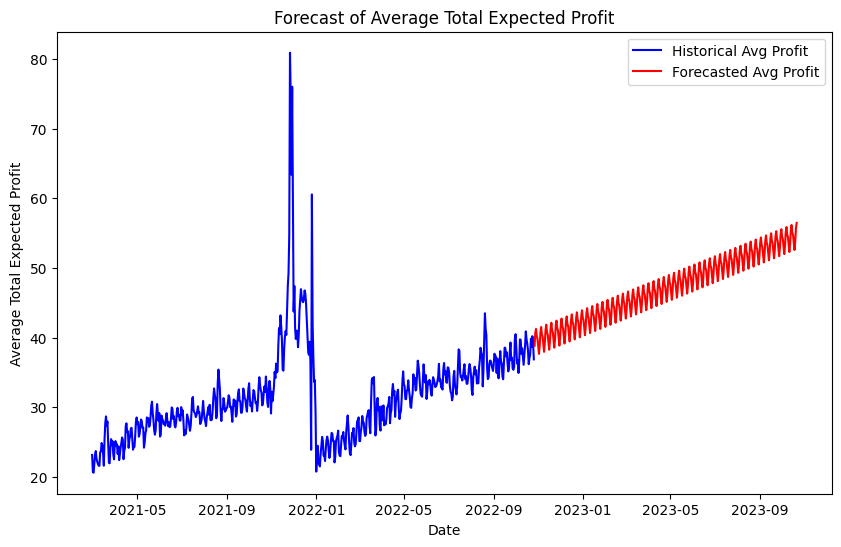

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract date and profit from the historical data up to 2022-10-26
historical_data = aggregated_df[['avg_total_expected_profit']].loc[:'2022-10-26']

# Create a new DataFrame for the forecasted values
forecast = best_model.get_forecast(steps=360)
forecast_profit = forecast.predicted_mean
forecast_dates = pd.date_range(start='2022-10-27', periods=360, freq='D')

# Create the forecast DataFrame
forecast_df_profit = pd.DataFrame(forecast_profit, index=forecast_dates, columns=['predicted_mean'])

# Rename 'predicted_mean' to 'avg_total_expected_profit' to match historical data
forecast_df_profit.rename(columns={'predicted_mean': 'avg_total_expected_profit'}, inplace=True)

# Ensure the forecast DataFrame index has the same name as the historical index
forecast_df_profit.index.name = 'order_datetime'

# Concatenate historical and forecast data
combined_data = pd.concat([historical_data, forecast_df_profit])

# Plot the historical data in blue and the forecast data in red
plt.figure(figsize=(10, 6))

# Plot historical data in blue
plt.plot(combined_data.loc[:'2022-10-26'].index, combined_data.loc[:'2022-10-26', 'avg_total_expected_profit'], label="Historical Avg Profit", color='blue')

# Plot forecast data in red
plt.plot(combined_data.loc['2022-10-27':].index, combined_data.loc['2022-10-27':, 'avg_total_expected_profit'], label="Forecasted Avg Profit", color='red')

# Add labels and title
plt.title("Forecast of Average Total Expected Profit")
plt.xlabel('Date')
plt.ylabel('Average Total Expected Profit')
plt.legend()
plt.show()

In [18]:
from pyspark.sql.types import FloatType
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress the ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def forecast_profit(merchant_data_pd):
    try:
        # Convert to pandas DataFrame and set index
        merchant_data_pd = pd.DataFrame(merchant_data_pd, columns=['order_datetime', 'total_expected_profit'])
        merchant_data_pd['order_datetime'] = pd.to_datetime(merchant_data_pd['order_datetime'])
        merchant_data_pd.set_index('order_datetime', inplace=True)
        merchant_data_pd = merchant_data_pd.sort_index()

        # Set frequency to 'D' (daily) or another appropriate frequency
        merchant_data_pd = merchant_data_pd.asfreq('D')  # Adjust frequency if necessary

        # Check if the merchant has sufficient data to fit the model
        if len(merchant_data_pd) < 2:
            print(f"Not enough data for merchant")
            return None

        # Train SARIMAX model
        model = SARIMAX(merchant_data_pd['total_expected_profit'], 
                        order=(1, 1, 3), 
                        seasonal_order=(2, 1, 2, 7), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        result = model.fit(disp=False)

        # Check for convergence issues
        if not result.mle_retvals['converged']:
            print(f"Model failed to converge for merchant.")
            return None

        # Forecast the next 6 months (180 days)
        forecast = result.get_forecast(steps=180)
        forecast_profit = forecast.predicted_mean

        # Sum of the forecasted total profit for 6 months
        total_forecasted_profit = float(forecast_profit.sum())
        print(f"Forecast for merchant done successfully.")

        return total_forecasted_profit
    except Exception as e:
        print(f"Error in processing: {e}")
        return None

# Register the function as a UDF (User Defined Function)
forecast_udf = F.udf(forecast_profit, FloatType())

# Apply the UDF to group data and forecast for each merchant
merchant_forecasts = merchants_profit_grouped.groupBy('merchant_abn').agg(
    F.collect_list(F.struct('order_datetime', 'total_expected_profit')).alias('merchant_data')
).withColumn('predict_6_months_total_profit', forecast_udf('merchant_data'))

# Show results
merchant_forecasts.select('merchant_abn', 'predict_6_months_total_profit').show(100)

24/10/01 08:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:09:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:09:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:09:30 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+-----------------------------+
|merchant_abn|predict_6_months_total_profit|
+------------+-----------------------------+
| 10023283211|                         NULL|
| 10342410215|                    6481.7075|
| 10346855916|                     36.94143|
| 10385163239|                         NULL|
| 10648956813|                         NULL|
| 10714068705|                         NULL|
| 11024352823|                         NULL|
| 11076688542|                     428.6629|
| 11243046390|                         NULL|
| 11633090957|                         NULL|
| 11848576000|                         NULL|
| 11944993446|                         NULL|
| 12219088747|                         NULL|
| 12476477880|                    250.78058|
| 12516851436|                         NULL|
| 12771097467|                         NULL|
| 13066244467|                         NULL|
| 13067850740|                         NULL|
| 13120157976|                         NULL|
| 13159730

Forecast for merchant done successfully.


# Export the data

In [ ]:
# Checking the number of rows
row_count = merchant_forecasts.count()

# Checking for missing values in 'predict_6_months_total_profit'
missing_values_count = merchant_forecasts.filter(merchant_forecasts['predict_6_months_total_profit'].isNull()).count()

print(f"Total Rows: {row_count}")
print(f"Missing Values in 'predict_6_months_total_profit': {missing_values_count}")

24/10/01 08:15:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:15:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:15:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:15:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:15:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:15:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:15:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:15:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/01 08:15:39 WARN RowBasedKeyValueBatch: Calling spill() on

In [ ]:
merchant_forecasts.select('merchant_abn', 'predict_6_months_total_profit').show(100)